## Ekstraksi dan Persiapan Data

In [1]:
import pandas as pd
import os
import tarfile
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ekstrak file
tar_path = '/content/drive/MyDrive/Tugas PBA/ag_news_csv.tar.gz'  # Path ke file
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall('./data')

In [2]:
# Load dataset
train_data = pd.read_csv('./data/ag_news_csv/train.csv', header=None)
test_data = pd.read_csv('./data/ag_news_csv/test.csv', header=None)

# Rename columns
train_data.columns = ['label', 'title', 'description']
test_data.columns = ['label', 'title', 'description']

# Combine title and description
train_data['text'] = train_data['title'] + ' ' + train_data['description']
test_data['text'] = test_data['title'] + ' ' + test_data['description']

# Adjust labels to start from 0
train_data['label'] -= 1
test_data['label'] -= 1

# Split train data for validation
X_train, X_val, y_train, y_val = train_test_split(train_data['text'], train_data['label'], test_size=0.2, random_state=42)
X_test, y_test = test_data['text'], test_data['label']

## GloVe Embedding

In [3]:
# Load GloVe embeddings
glove_path = '/content/drive/MyDrive/Tugas PBA/glove.6B.100d.txt'  # Path ke GloVe file
embedding_dim = 100

def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings(glove_path)

# Tokenization
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


## Model LSTM

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model LSTM
def create_lstm_model(max_words, embedding_dim, max_len, num_classes, embedding_matrix):
    model = Sequential([
        # Layer embedding dengan bobot dari embedding matrix
        Embedding(max_words, embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_len,
                  trainable=False),

        # LSTM Layer
        LSTM(128, return_sequences=True),
        BatchNormalization(),

        # Layer LSTM kedua
        LSTM(64),
        BatchNormalization(),

        # Dense layers untuk klasifikasi
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Persiapan label
num_classes = len(np.unique(train_data['label']))
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Inisialisasi dan training model
model = create_lstm_model(
    max_words,
    embedding_dim,
    max_len,
    num_classes,
    embedding_matrix
)

# Early stopping dan model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_seq, y_val),
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8386 - loss: 0.4701 - val_accuracy: 0.9031 - val_loss: 0.2825
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9009 - loss: 0.3019 - val_accuracy: 0.9107 - val_loss: 0.2605
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9136 - loss: 0.2622 - val_accuracy: 0.9132 - val_loss: 0.2576
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9180 - loss: 0.2412 - val_accuracy: 0.9181 - val_loss: 0.2361
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9260 - loss: 0.2163 - val_accuracy: 0.9202 - val_loss: 0.2327


## Evaluasi Model

In [5]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Prediksi pada test set
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

# Laporan klasifikasi
print("\nklasifikasi Report:")
print(classification_report(y_test, y_pred_classes))

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9148 - loss: 0.2545
Test Loss: 0.24296726286411285
Test Accuracy: 91.87%
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

klasifikasi Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1900
           1       0.97      0.98      0.97      1900
           2       0.87      0.89      0.88      1900
           3       0.89      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



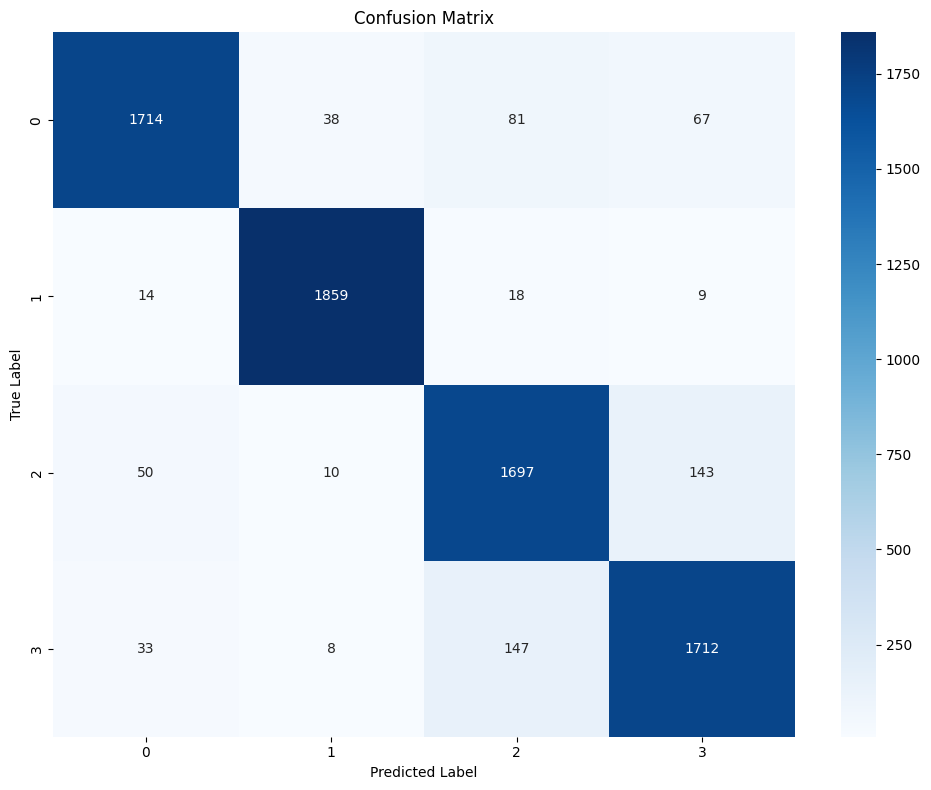

In [6]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

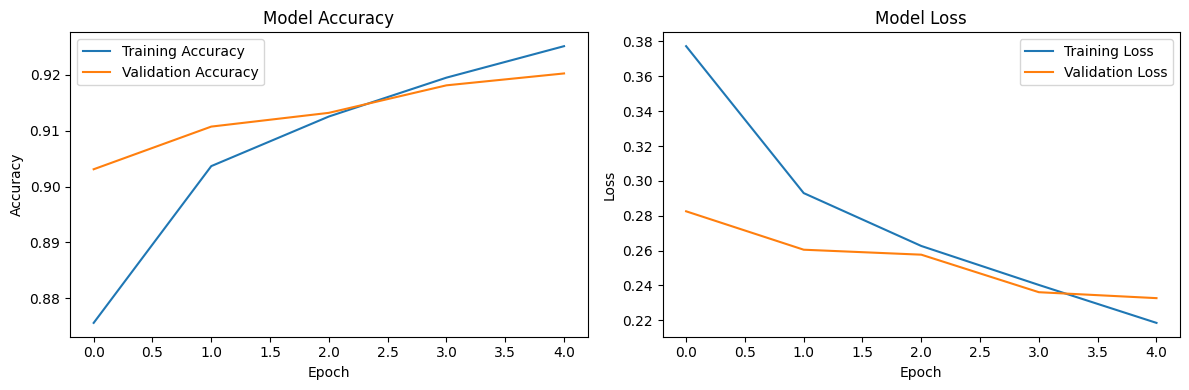

In [7]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Fast Text

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7431 - loss: 0.7023 - val_accuracy: 0.9125 - val_loss: 0.2683
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9251 - loss: 0.2256 - val_accuracy: 0.9189 - val_loss: 0.2439
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9399 - loss: 0.1758 - val_accuracy: 0.9205 - val_loss: 0.2430
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9484 - loss: 0.1519 - val_accuracy: 0.9170 - val_loss: 0.2524
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9539 - loss: 0.1316 - val_accuracy: 0.9104 - val_loss: 0.2704

--- Evaluasi Model FastText ---
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9104 - loss: 0.2887
Test Accuracy: 91.55%
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

klasifikasi Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1900
           1       0.96      0.98      0.97      1900
          

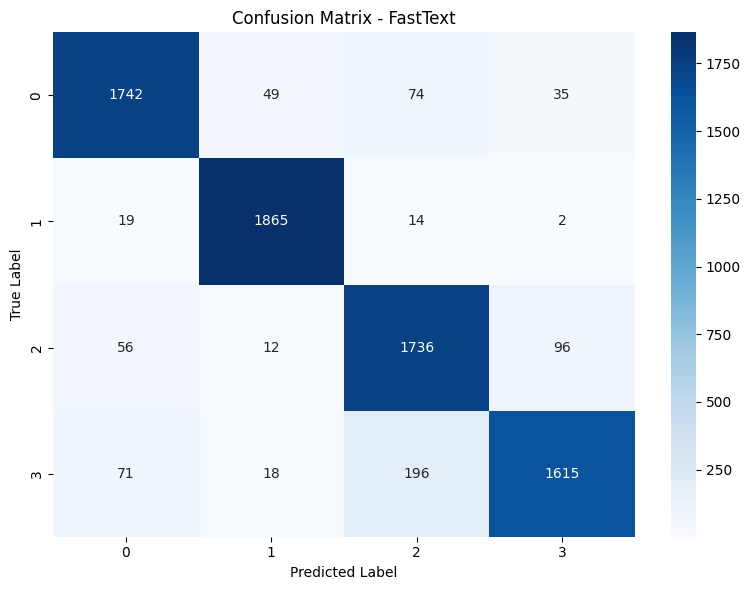

In [8]:
# FastText Model
def create_fasttext_model(max_words, embedding_dim, max_len, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_words, embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameters
num_classes = len(np.unique(train_data['label']))
embedding_dim = 100

# Evaluasi Model
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- Evaluasi Model {model_name} ---")

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print("\nklasifikasi Report:")
    print(classification_report(y_test, y_pred_classes))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Training FastText
ft_model = create_fasttext_model(max_words, embedding_dim, max_len, num_classes)
ft_history = ft_model.fit(
    X_train_seq, y_train,
    epochs=5,
    validation_data=(X_val_seq, y_val),
    batch_size=64
)

# Evaluasi FastText
evaluate_model(ft_model, X_test_seq, y_test, "FastText")

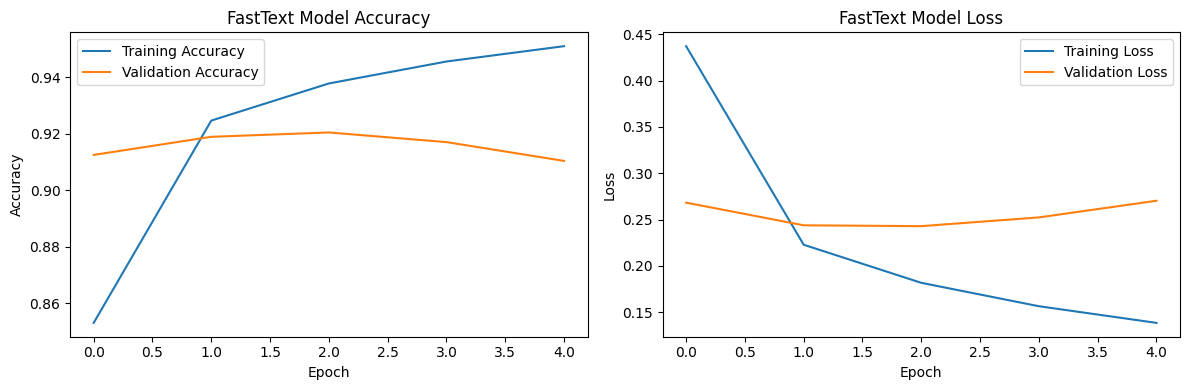

In [9]:
# Plot Training History for FastText
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ft_history.history['accuracy'], label='Training Accuracy')
plt.plot(ft_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('FastText Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ft_history.history['loss'], label='Training Loss')
plt.plot(ft_history.history['val_loss'], label='Validation Loss')
plt.title('FastText Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Transformer

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.7270 - loss: 0.6357 - val_accuracy: 0.9183 - val_loss: 0.2467
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.9397 - loss: 0.1764 - val_accuracy: 0.9165 - val_loss: 0.2519
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9528 - loss: 0.1351 - val_accuracy: 0.9115 - val_loss: 0.2740
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 84s 31ms/step - accuracy: 0.9616 - loss: 0.1032 - val_accuracy: 0.9048 - val_loss: 0.3600
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - accuracy: 0.9672 - loss: 0.0860 - val_accuracy: 0.9015 - val_loss: 0.3671

--- Evaluasi Model Transformer ---
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8996 - loss: 0.3665
Test Accuracy: 90.30%
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

klasifikasi Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1900
           1       0.95      0.96      0

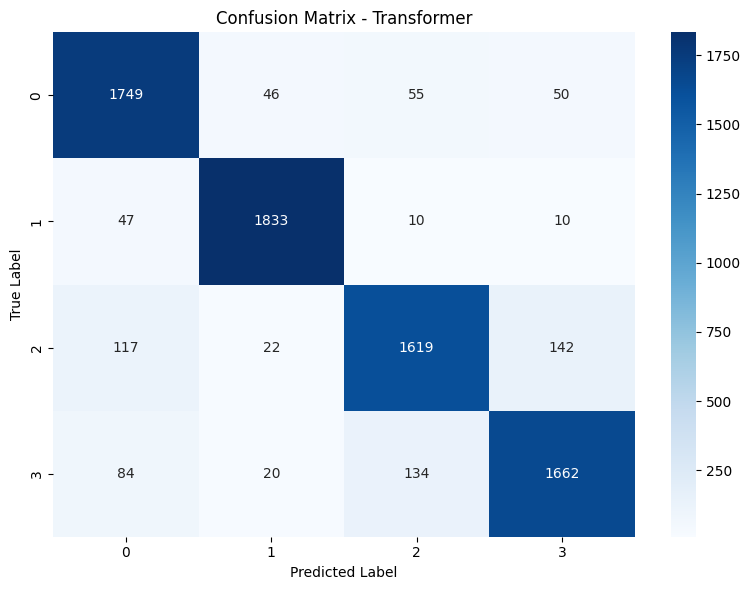

In [10]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed-forward network
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Transformer Model
def create_transformer_model(max_words, embedding_dim, max_len, num_classes):
    inputs = tf.keras.Input(shape=(max_len,))
    embedding = tf.keras.layers.Embedding(max_words, embedding_dim)(inputs)

    x = embedding
    for _ in range(2):  # 2 transformer layers
        x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=32)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameters
num_classes = len(np.unique(train_data['label']))
embedding_dim = 100

# Evaluasi Model
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- Evaluasi Model {model_name} ---")

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print("\nklasifikasi Report:")
    print(classification_report(y_test, y_pred_classes))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Training Transformer
transformer_model = create_transformer_model(max_words, embedding_dim, max_len, num_classes)
transformer_history = transformer_model.fit(
    X_train_seq, y_train,
    epochs=5,
    validation_data=(X_val_seq, y_val),
    batch_size=64
)

# Evaluasi Transformer
evaluate_model(transformer_model, X_test_seq, y_test, "Transformer")

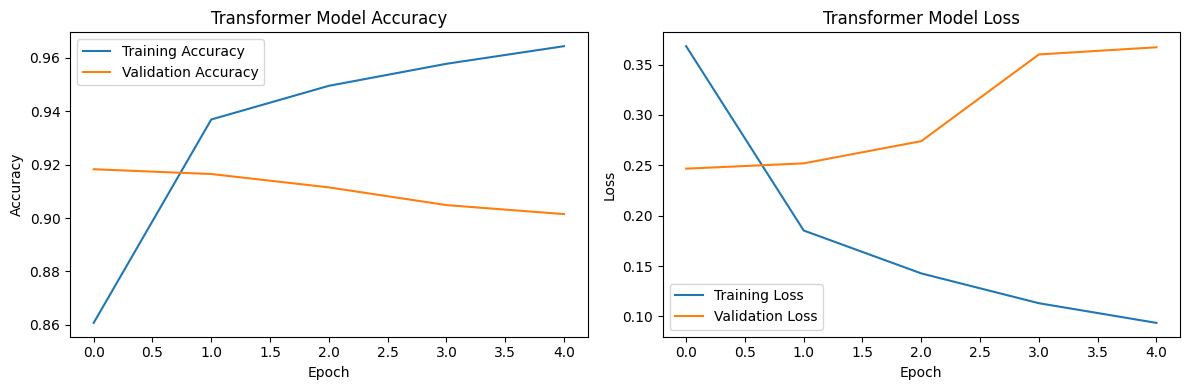

In [11]:
# Plot Training History for Transformer
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(transformer_history.history['accuracy'], label='Training Accuracy')
plt.plot(transformer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(transformer_history.history['loss'], label='Training Loss')
plt.plot(transformer_history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## BERT